# Christian Prosser
# Id: gpm6tf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pyspark.sql.functions as F
import regex as re
import seaborn as sns

from IPython.display import display
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import *
from typing import *

In [2]:
path = '/project/ds5559/group2nba'

In [3]:
spark = SparkSession \
    .builder \
    .appName('group2nba') \
    .getOrCreate()

In [4]:
RESPONSE = 'Won'
PLAYER_COLS = [
      'Shooter'
    , 'Assister'
    , 'Blocker'
    , 'Fouler'
    , 'Fouled'
    , 'Rebounder'
    , 'ViolationPlayer'
    , 'FreeThrowShooter'
    , 'TurnoverPlayer'
    , 'TurnoverCauser'
    , 'JumpballAwayPlayer'
    , 'JumpballHomePlayer'
    , 'JumpballPoss'
]

In [14]:
def create_response(winner: str, team: str) -> int:
    '''...'''
    return int(winner == team)

def create_player_predictor(player: str) -> int:
    '''...'''
    return int(player is not None)

def get_cols(df: DataFrame, columns: List[str]) -> DataFrame:
    '''Selects the specified subset of the specified DataFrame'''
    return df.select(columns).dropna()

def subset(df: DataFrame, predictors: List[str]) -> DataFrame:
    '''Selects the specified subset of the specified DataFrame for predictions of winning team'''
    
    home = df.select(['Date', 'WinningTeam', 'HomeTeam', 'HomePlay'] + predictors) \
        .withColumn('Won', F.UserDefinedFunction(create_response, IntegerType())('WinningTeam', 'HomeTeam')) \
        .na.drop(subset = ['HomePlay']) \
        .drop('WinningTeam', 'HomeTeam', 'HomePlay')
    
    away = df.select(['Date', 'WinningTeam', 'AwayTeam', 'AwayPlay'] + predictors) \
        .withColumn('Won', F.UserDefinedFunction(create_response, IntegerType())('WinningTeam', 'AwayTeam')) \
        .na.drop(subset = ['AwayPlay']) \
        .drop('WinningTeam', 'AwayTeam', 'AwayPlay')
    
    subset = home.union(away).drop('Date')
    
    players = [p for p in predictors if p in PLAYER_COLS]
    
    for col in players:
        subset = subset.withColumn(col, F.UserDefinedFunction(create_player_predictor, IntegerType())(col))
        
#     return subset
        
    # TRY THE AGG(*[(F.SUM(X) / F.COUNT('DATE')).ALIAS(X) FOR X IN PLAYERS])
    # AGAIN, SOMETHING WEIRD WITH MAKING FLOATTYPE IN THE ABOVE UDF.........
    return subset \
        .groupBy(['Date', 'Won']) \
        .agg(*[F.sum(x).alias(x) for x in players]) \
        .drop('Date')

In [8]:
DATA_FIELDS = {
      'Url': StringType
    , 'GameType': StringType
    , 'Location': StringType
    , 'Date': StringType # ?
    , 'Time': StringType # ?
    , 'WinningTeam': StringType
    , 'Quarter': IntegerType
    , 'SecLeft': IntegerType
    , 'AwayTeam': StringType
    , 'AwayPlay': StringType
    , 'AwayScore': IntegerType
    , 'HomeTeam': StringType
    , 'HomePlay': StringType
    , 'HomeScore': IntegerType
    , 'Shooter': StringType
    , 'ShotType': StringType
    , 'ShotOutcome': IntegerType
    , 'ShotDist': IntegerType
    , 'Assister': StringType
    , 'Blocker': StringType
    , 'FoulType': StringType # ?
    , 'Fouler': StringType
    , 'Fouled': StringType
    , 'Rebounder': StringType
    , 'ReboundType': IntegerType
    , 'ViolationPlayer': StringType
    , 'ViolationType': StringType  # ?
    , 'TimeoutTeam': StringType
    , 'FreeThrowShooter': StringType
    , 'FreeThrowOutcome': IntegerType
    , 'FreeThrowNum': StringType # ?
    , 'EnterGame': StringType
    , 'LeaveGame': StringType
    , 'TurnoverPlayer': StringType
    , 'TurnoverType': StringType # ?
    , 'TurnoverCause': StringType # ?
    , 'TurnoverCauser': StringType
    , 'JumpballAwayPlayer': StringType
    , 'JumpballHomePlayer': StringType
    , 'JumpballPoss': StringType
}

In [9]:
schema = StructType([StructField(k, v()) for k, v in DATA_FIELDS.items()])

TRAIN = spark.read \
    .format('csv') \
    .option('header', True) \
    .schema(schema) \
    .load(f'{path}/NBA_PBP_2015-16.csv')

display(TRAIN.count())
display(TRAIN.printSchema())
display(TRAIN.head(2))

601557

root
 |-- Url: string (nullable = true)
 |-- GameType: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- WinningTeam: string (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- SecLeft: integer (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- AwayPlay: string (nullable = true)
 |-- AwayScore: integer (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- HomePlay: string (nullable = true)
 |-- HomeScore: integer (nullable = true)
 |-- Shooter: string (nullable = true)
 |-- ShotType: string (nullable = true)
 |-- ShotOutcome: integer (nullable = true)
 |-- ShotDist: integer (nullable = true)
 |-- Assister: string (nullable = true)
 |-- Blocker: string (nullable = true)
 |-- FoulType: string (nullable = true)
 |-- Fouler: string (nullable = true)
 |-- Fouled: string (nullable = true)
 |-- Rebounder: string (nullable = true)
 |-- ReboundType: integer (nullable = tru

None

[Row(Url='/boxscores/201510270ATL.html', GameType='regular', Location='Philips Arena Atlanta Georgia', Date='October 27 2015', Time='8:00 PM', WinningTeam='DET', Quarter=1, SecLeft=720, AwayTeam='DET', AwayPlay='Jump ball: A. Drummond vs. A. Horford (E. lyasova gains possession)', AwayScore=0, HomeTeam='ATL', HomePlay=None, HomeScore=0, Shooter=None, ShotType=None, ShotOutcome=None, ShotDist=None, Assister=None, Blocker=None, FoulType=None, Fouler=None, Fouled=None, Rebounder=None, ReboundType=None, ViolationPlayer=None, ViolationType=None, TimeoutTeam=None, FreeThrowShooter=None, FreeThrowOutcome=None, FreeThrowNum=None, EnterGame=None, LeaveGame=None, TurnoverPlayer=None, TurnoverType=None, TurnoverCause=None, TurnoverCauser=None, JumpballAwayPlayer='A. Drummond - drumman01', JumpballHomePlayer='A. Horford - horfoal01', JumpballPoss='E. İlyasova - ilyaser01'),
 Row(Url='/boxscores/201510270ATL.html', GameType='regular', Location='Philips Arena Atlanta Georgia', Date='October 27 2015'

In [10]:
df_subset1 = get_cols(TRAIN, ['Shooter', 'ShotType', 'ShotOutcome'])
df_subset1.count()

0

In [11]:
_shooters = df_subset1 \
    .groupby('Shooter') \
    .agg(F.mean('ShotOutcome')
        .alias('Avg')) \
    .sort(F.desc('Avg')) \
    .select('Shooter') \
    .take(10)
top10 = [x[0] for x in _shooters]
top10

[]

In [32]:
df_top10_shooters = df_subset1 \
    .where(F.col('Shooter').isin(top10)) \
    .toPandas()
display(df_top10_shooters.shape)
display(df_top10_shooters.head(5))

(3731, 3)

Shooter        ShotType  ShotOutcome
0  D. Jordan - jordade01       2-pt dunk            1
1  D. Jordan - jordade01      2-pt layup            1
2  D. Jordan - jordade01      2-pt layup            1
3  D. Jordan - jordade01  2-pt jump shot            0
4  D. Jordan - jordade01  2-pt jump shot            0

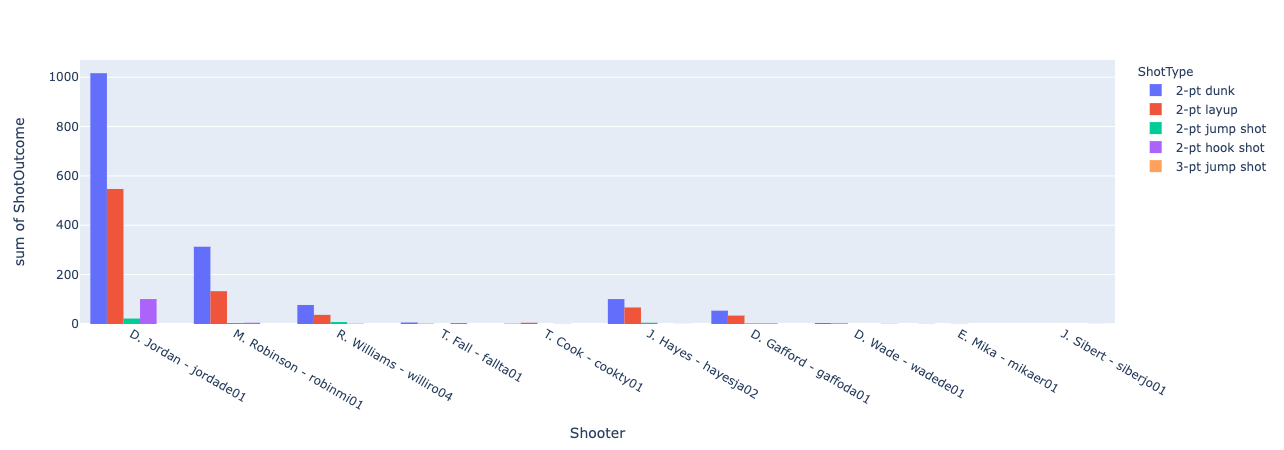

In [33]:
fig = px.histogram(
      df_top10_shooters
    , x = 'Shooter'
    , y = 'ShotOutcome'
    , color = 'ShotType'
    , barmode = 'group'
)
fig.show()

In [12]:
# fig = px.histogram(
#       df_top10_shooters.query('Shooter != "D. Jordan - jordade01"')
#     , x = 'Shooter'
#     , y = 'ShotOutcome'
#     , color = 'ShotType'
#     , barmode = 'group'
# )
# fig.show()

In [15]:
df_subset2 = get_cols(TRAIN, ['WinningTeam', 'Date'])

_winners = df_subset2 \
    .groupBy(['WinningTeam', 'Date']) \
    .agg(F.countDistinct('*') \
         .alias('Count')) \
    .sort(F.desc('Count')) \
    .toPandas()

_winners

WinningTeam              Date  Count
0            DEN  November 13 2015      1
1            GSW  November 20 2015      1
2            BRK   January 24 2016      1
3            BOS      March 9 2016      1
4            DEN     March 10 2016      1
...          ...               ...    ...
1311         CHI  February 24 2016      1
1312         MEM     March 21 2016      1
1313         PHI      April 5 2016      1
1314         PHO      April 9 2016      1
1315         SAS     April 30 2016      1

[1316 rows x 3 columns]

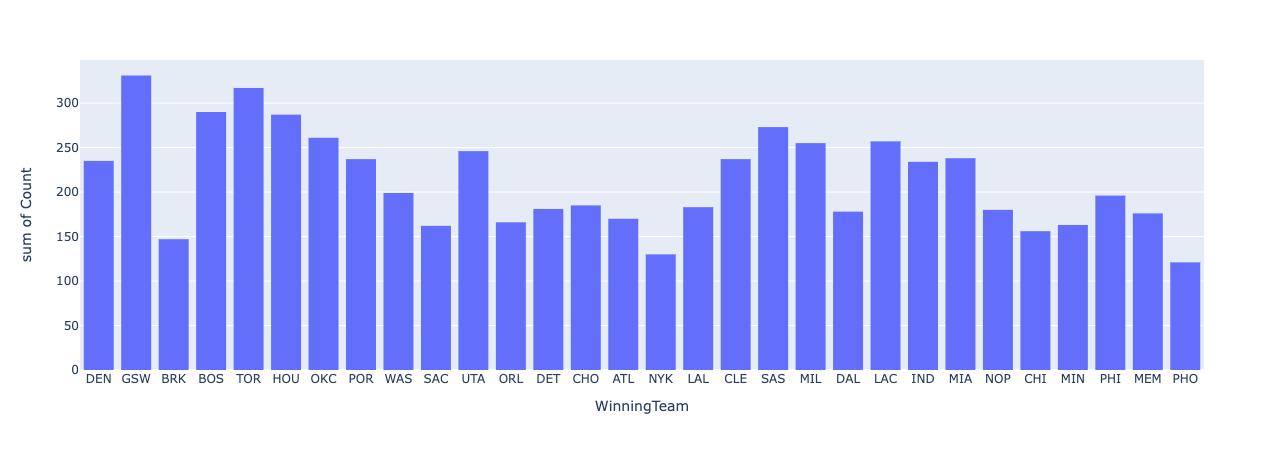

In [35]:
fig = px.histogram(
      _winners
    , x = 'WinningTeam'
    , y = 'Count'
    # , color = 'ShotType'
    # , barmode = 'group'
)
fig.show()

In [16]:
df_1 = subset(TRAIN, PLAYER_COLS)
df_1.head(10)

AnalysisException: cannot resolve '`Date`' given input columns: [Assister, Blocker, Fouled, Fouler, FreeThrowShooter, JumpballAwayPlayer, JumpballHomePlayer, JumpballPoss, Rebounder, Shooter, TurnoverCauser, TurnoverPlayer, ViolationPlayer, Won];
'Aggregate ['Date, Won#433], ['Date, Won#433, sum(cast(Shooter#600 as bigint)) AS Shooter#822L, sum(cast(Assister#616 as bigint)) AS Assister#824L, sum(cast(Blocker#632 as bigint)) AS Blocker#826L, sum(cast(Fouler#648 as bigint)) AS Fouler#828L, sum(cast(Fouled#664 as bigint)) AS Fouled#830L, sum(cast(Rebounder#680 as bigint)) AS Rebounder#832L, sum(cast(ViolationPlayer#696 as bigint)) AS ViolationPlayer#834L, sum(cast(FreeThrowShooter#712 as bigint)) AS FreeThrowShooter#836L, sum(cast(TurnoverPlayer#728 as bigint)) AS TurnoverPlayer#838L, sum(cast(TurnoverCauser#744 as bigint)) AS TurnoverCauser#840L, sum(cast(JumpballAwayPlayer#760 as bigint)) AS JumpballAwayPlayer#842L, sum(cast(JumpballHomePlayer#776 as bigint)) AS JumpballHomePlayer#844L, sum(cast(JumpballPoss#792 as bigint)) AS JumpballPoss#846L]
+- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, ViolationPlayer#696, FreeThrowShooter#712, TurnoverPlayer#728, TurnoverCauser#744, JumpballAwayPlayer#760, JumpballHomePlayer#776, create_player_predictor(JumpballPoss#39) AS JumpballPoss#792, Won#433]
   +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, ViolationPlayer#696, FreeThrowShooter#712, TurnoverPlayer#728, TurnoverCauser#744, JumpballAwayPlayer#760, create_player_predictor(JumpballHomePlayer#38) AS JumpballHomePlayer#776, JumpballPoss#39, Won#433]
      +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, ViolationPlayer#696, FreeThrowShooter#712, TurnoverPlayer#728, TurnoverCauser#744, create_player_predictor(JumpballAwayPlayer#37) AS JumpballAwayPlayer#760, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
         +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, ViolationPlayer#696, FreeThrowShooter#712, TurnoverPlayer#728, create_player_predictor(TurnoverCauser#36) AS TurnoverCauser#744, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
            +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, ViolationPlayer#696, FreeThrowShooter#712, create_player_predictor(TurnoverPlayer#33) AS TurnoverPlayer#728, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
               +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, ViolationPlayer#696, create_player_predictor(FreeThrowShooter#28) AS FreeThrowShooter#712, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                  +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, Rebounder#680, create_player_predictor(ViolationPlayer#25) AS ViolationPlayer#696, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                     +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, Fouled#664, create_player_predictor(Rebounder#23) AS Rebounder#680, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                        +- Project [Shooter#600, Assister#616, Blocker#632, Fouler#648, create_player_predictor(Fouled#22) AS Fouled#664, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                           +- Project [Shooter#600, Assister#616, Blocker#632, create_player_predictor(Fouler#21) AS Fouler#648, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                              +- Project [Shooter#600, Assister#616, create_player_predictor(Blocker#19) AS Blocker#632, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                                 +- Project [Shooter#600, create_player_predictor(Assister#18) AS Assister#616, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                                    +- Project [create_player_predictor(Shooter#14) AS Shooter#600, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                                       +- Project [Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                                          +- Union false, false
                                             :- Project [Date#3, Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#433]
                                             :  +- Filter AtLeastNNulls(n, HomePlay#12)
                                             :     +- Project [Date#3, WinningTeam#5, HomeTeam#11, HomePlay#12, Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, create_response(WinningTeam#5, HomeTeam#11) AS Won#433]
                                             :        +- Project [Date#3, WinningTeam#5, HomeTeam#11, HomePlay#12, Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39]
                                             :           +- Relation[Url#0,GameType#1,Location#2,Date#3,Time#4,WinningTeam#5,Quarter#6,SecLeft#7,AwayTeam#8,AwayPlay#9,AwayScore#10,HomeTeam#11,HomePlay#12,HomeScore#13,Shooter#14,ShotType#15,ShotOutcome#16,ShotDist#17,Assister#18,Blocker#19,FoulType#20,Fouler#21,Fouled#22,Rebounder#23,... 16 more fields] csv
                                             +- Project [Date#3 AS Date#555, Shooter#14 AS Shooter#556, Assister#18 AS Assister#557, Blocker#19 AS Blocker#558, Fouler#21 AS Fouler#559, Fouled#22 AS Fouled#560, Rebounder#23 AS Rebounder#561, ViolationPlayer#25 AS ViolationPlayer#562, FreeThrowShooter#28 AS FreeThrowShooter#563, TurnoverPlayer#33 AS TurnoverPlayer#564, TurnoverCauser#36 AS TurnoverCauser#565, JumpballAwayPlayer#37 AS JumpballAwayPlayer#566, JumpballHomePlayer#38 AS JumpballHomePlayer#567, JumpballPoss#39 AS JumpballPoss#568, Won#503 AS Won#569]
                                                +- Project [Date#3, Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, Won#503]
                                                   +- Filter AtLeastNNulls(n, AwayPlay#9)
                                                      +- Project [Date#3, WinningTeam#5, AwayTeam#8, AwayPlay#9, Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39, create_response(WinningTeam#5, AwayTeam#8) AS Won#503]
                                                         +- Project [Date#3, WinningTeam#5, AwayTeam#8, AwayPlay#9, Shooter#14, Assister#18, Blocker#19, Fouler#21, Fouled#22, Rebounder#23, ViolationPlayer#25, FreeThrowShooter#28, TurnoverPlayer#33, TurnoverCauser#36, JumpballAwayPlayer#37, JumpballHomePlayer#38, JumpballPoss#39]
                                                            +- Relation[Url#0,GameType#1,Location#2,Date#3,Time#4,WinningTeam#5,Quarter#6,SecLeft#7,AwayTeam#8,AwayPlay#9,AwayScore#10,HomeTeam#11,HomePlay#12,HomeScore#13,Shooter#14,ShotType#15,ShotOutcome#16,ShotDist#17,Assister#18,Blocker#19,FoulType#20,Fouler#21,Fouled#22,Rebounder#23,... 16 more fields] csv


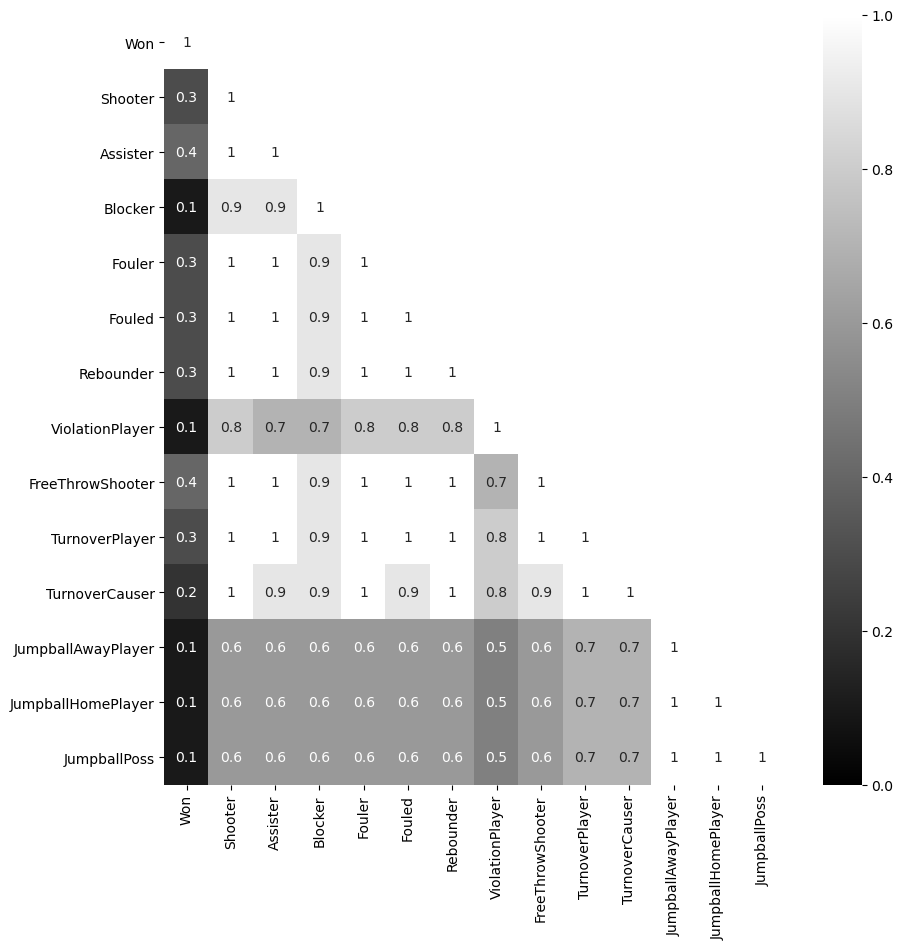

In [27]:
dfp = df_1.toPandas()

corr = np.round(np.absolute(dfp.head(50).corr()), 1)
cor_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

plt.figure(figsize = (10, 10))
sns.heatmap(
      data = cor_lt
    , annot = cor_lt
    , cmap = 'gray'
    , fmt = 'g'
    , vmin = 0
    , vmax = 1
)

plt.show()

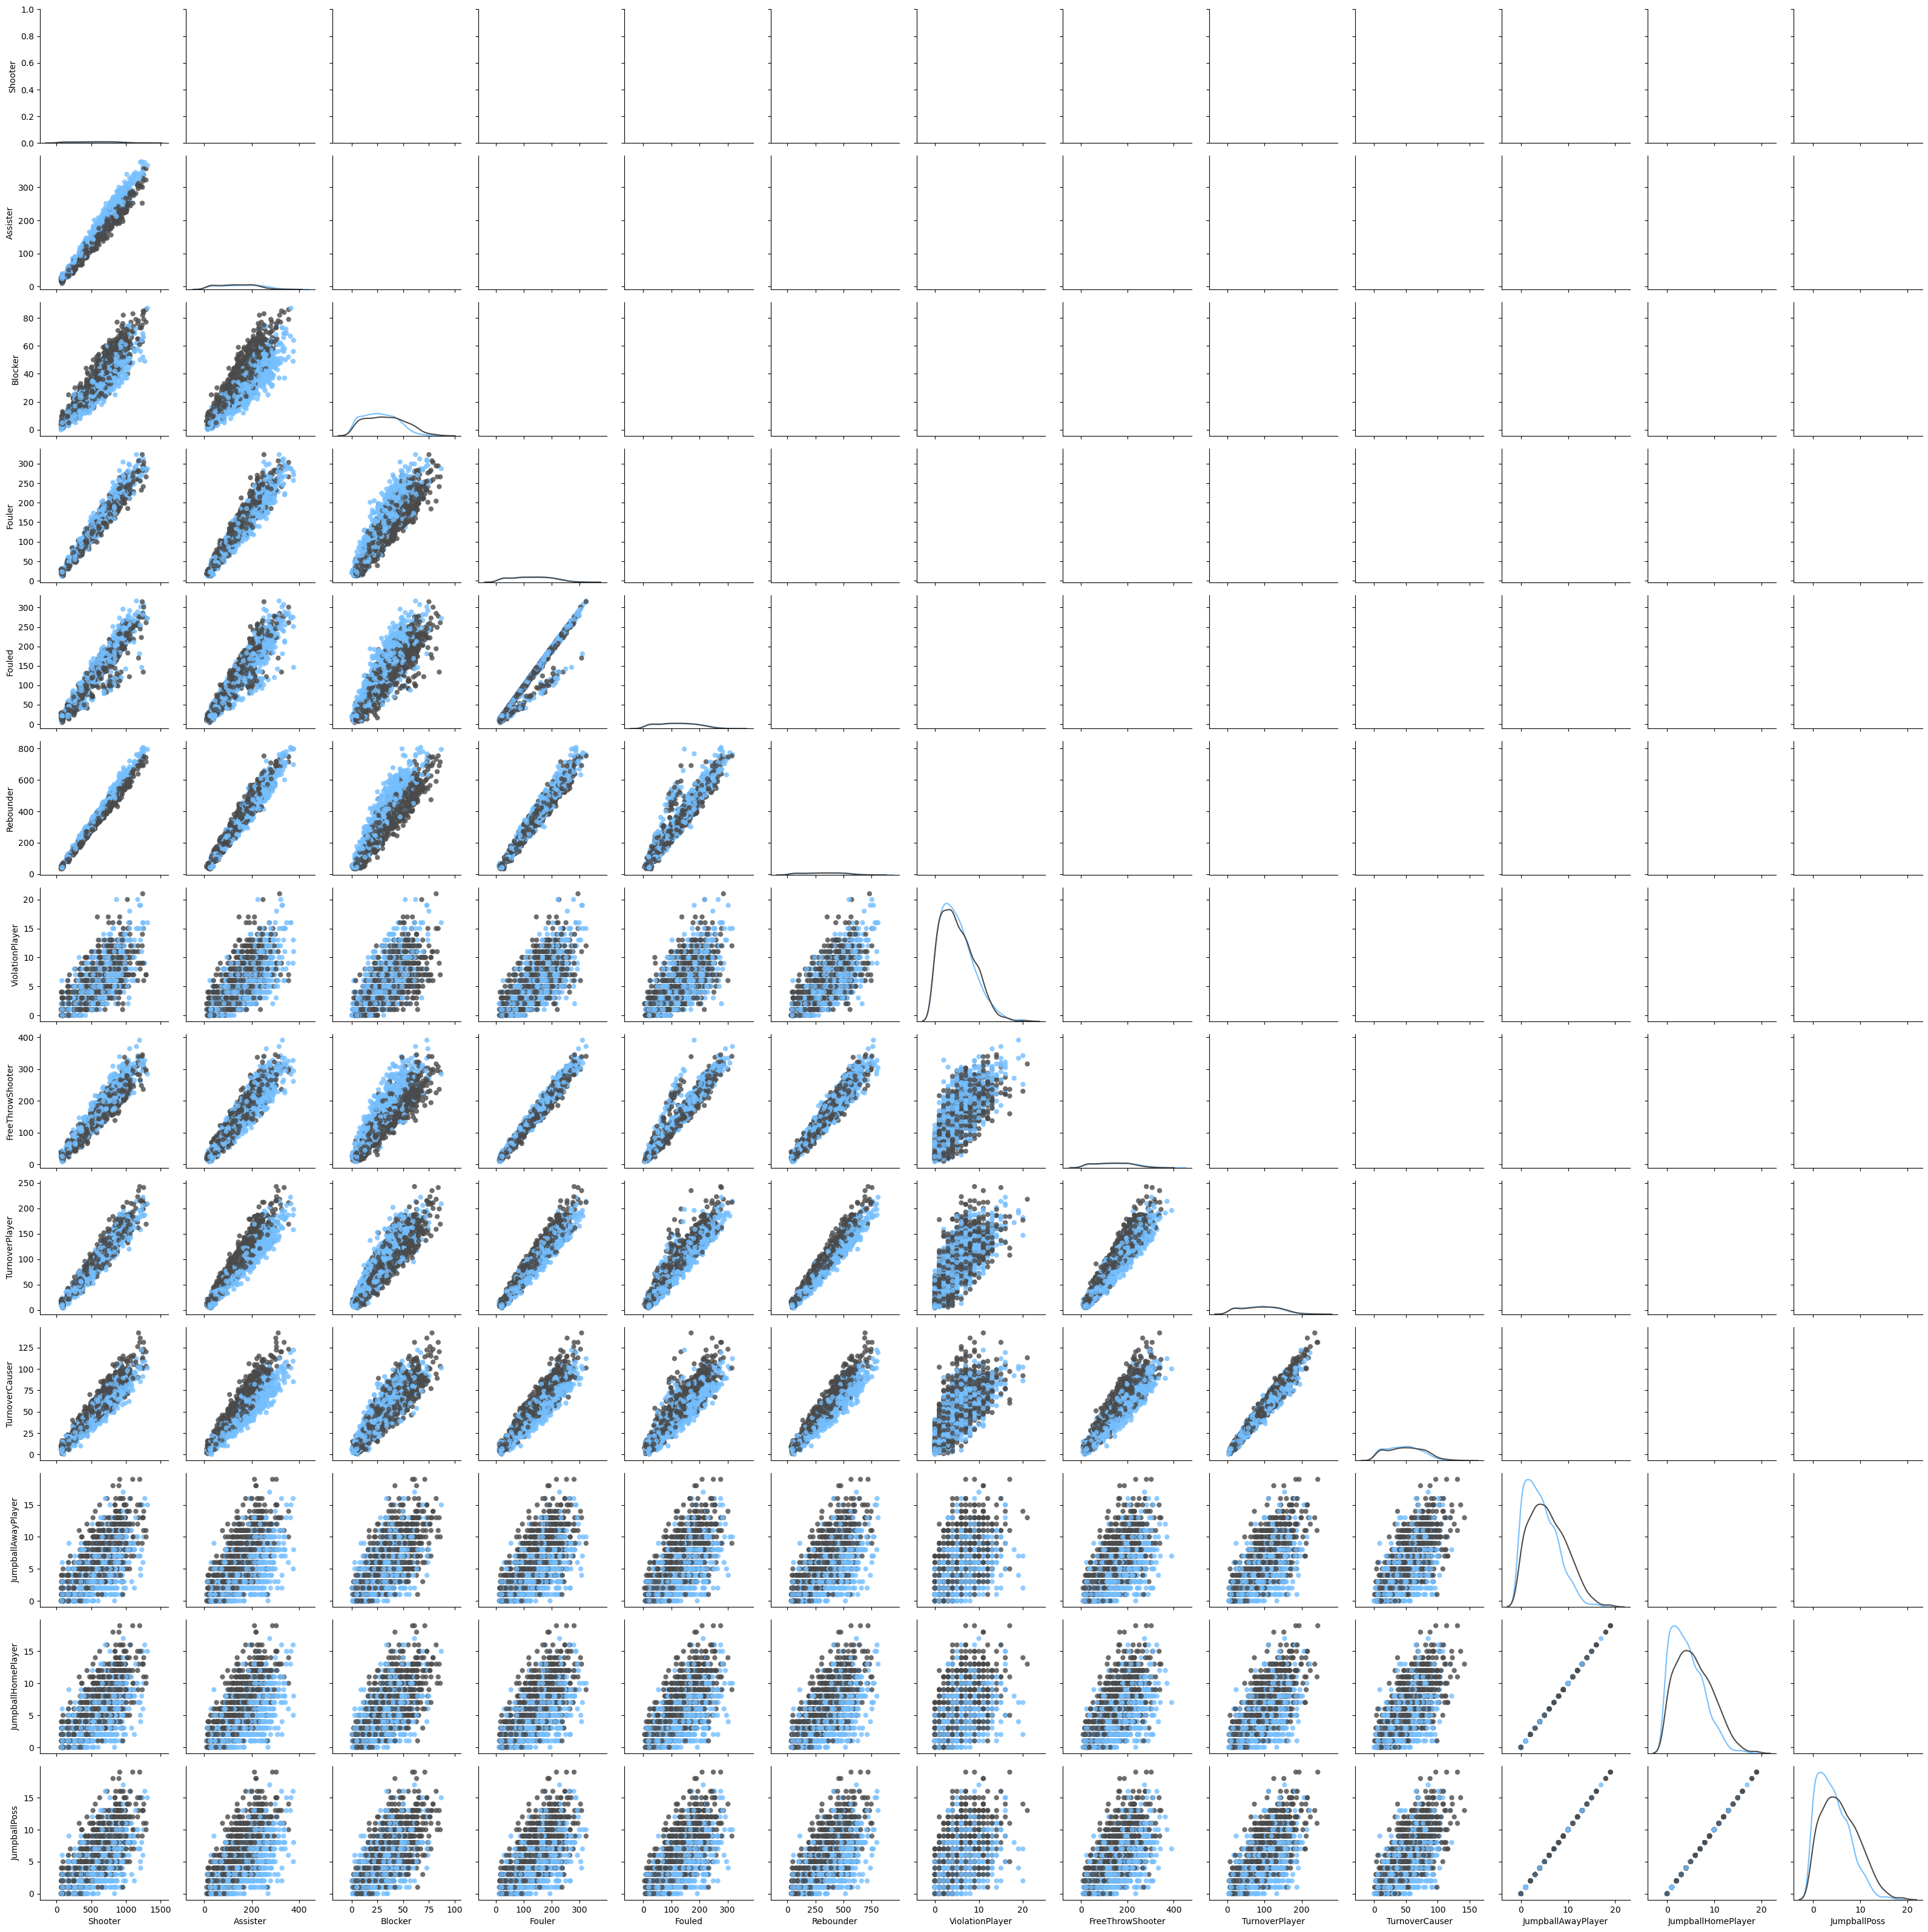

In [28]:
color_0 = '#4a4a4a'
color_1 = '#75bfff'
g = sns.PairGrid(
      dfp
    , hue = RESPONSE
    , palette = {
          0: color_0
        , 1: color_1
    }
)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot, **{
      'alpha': 0.8
    , 'linewidth': 0
})
plt.show()

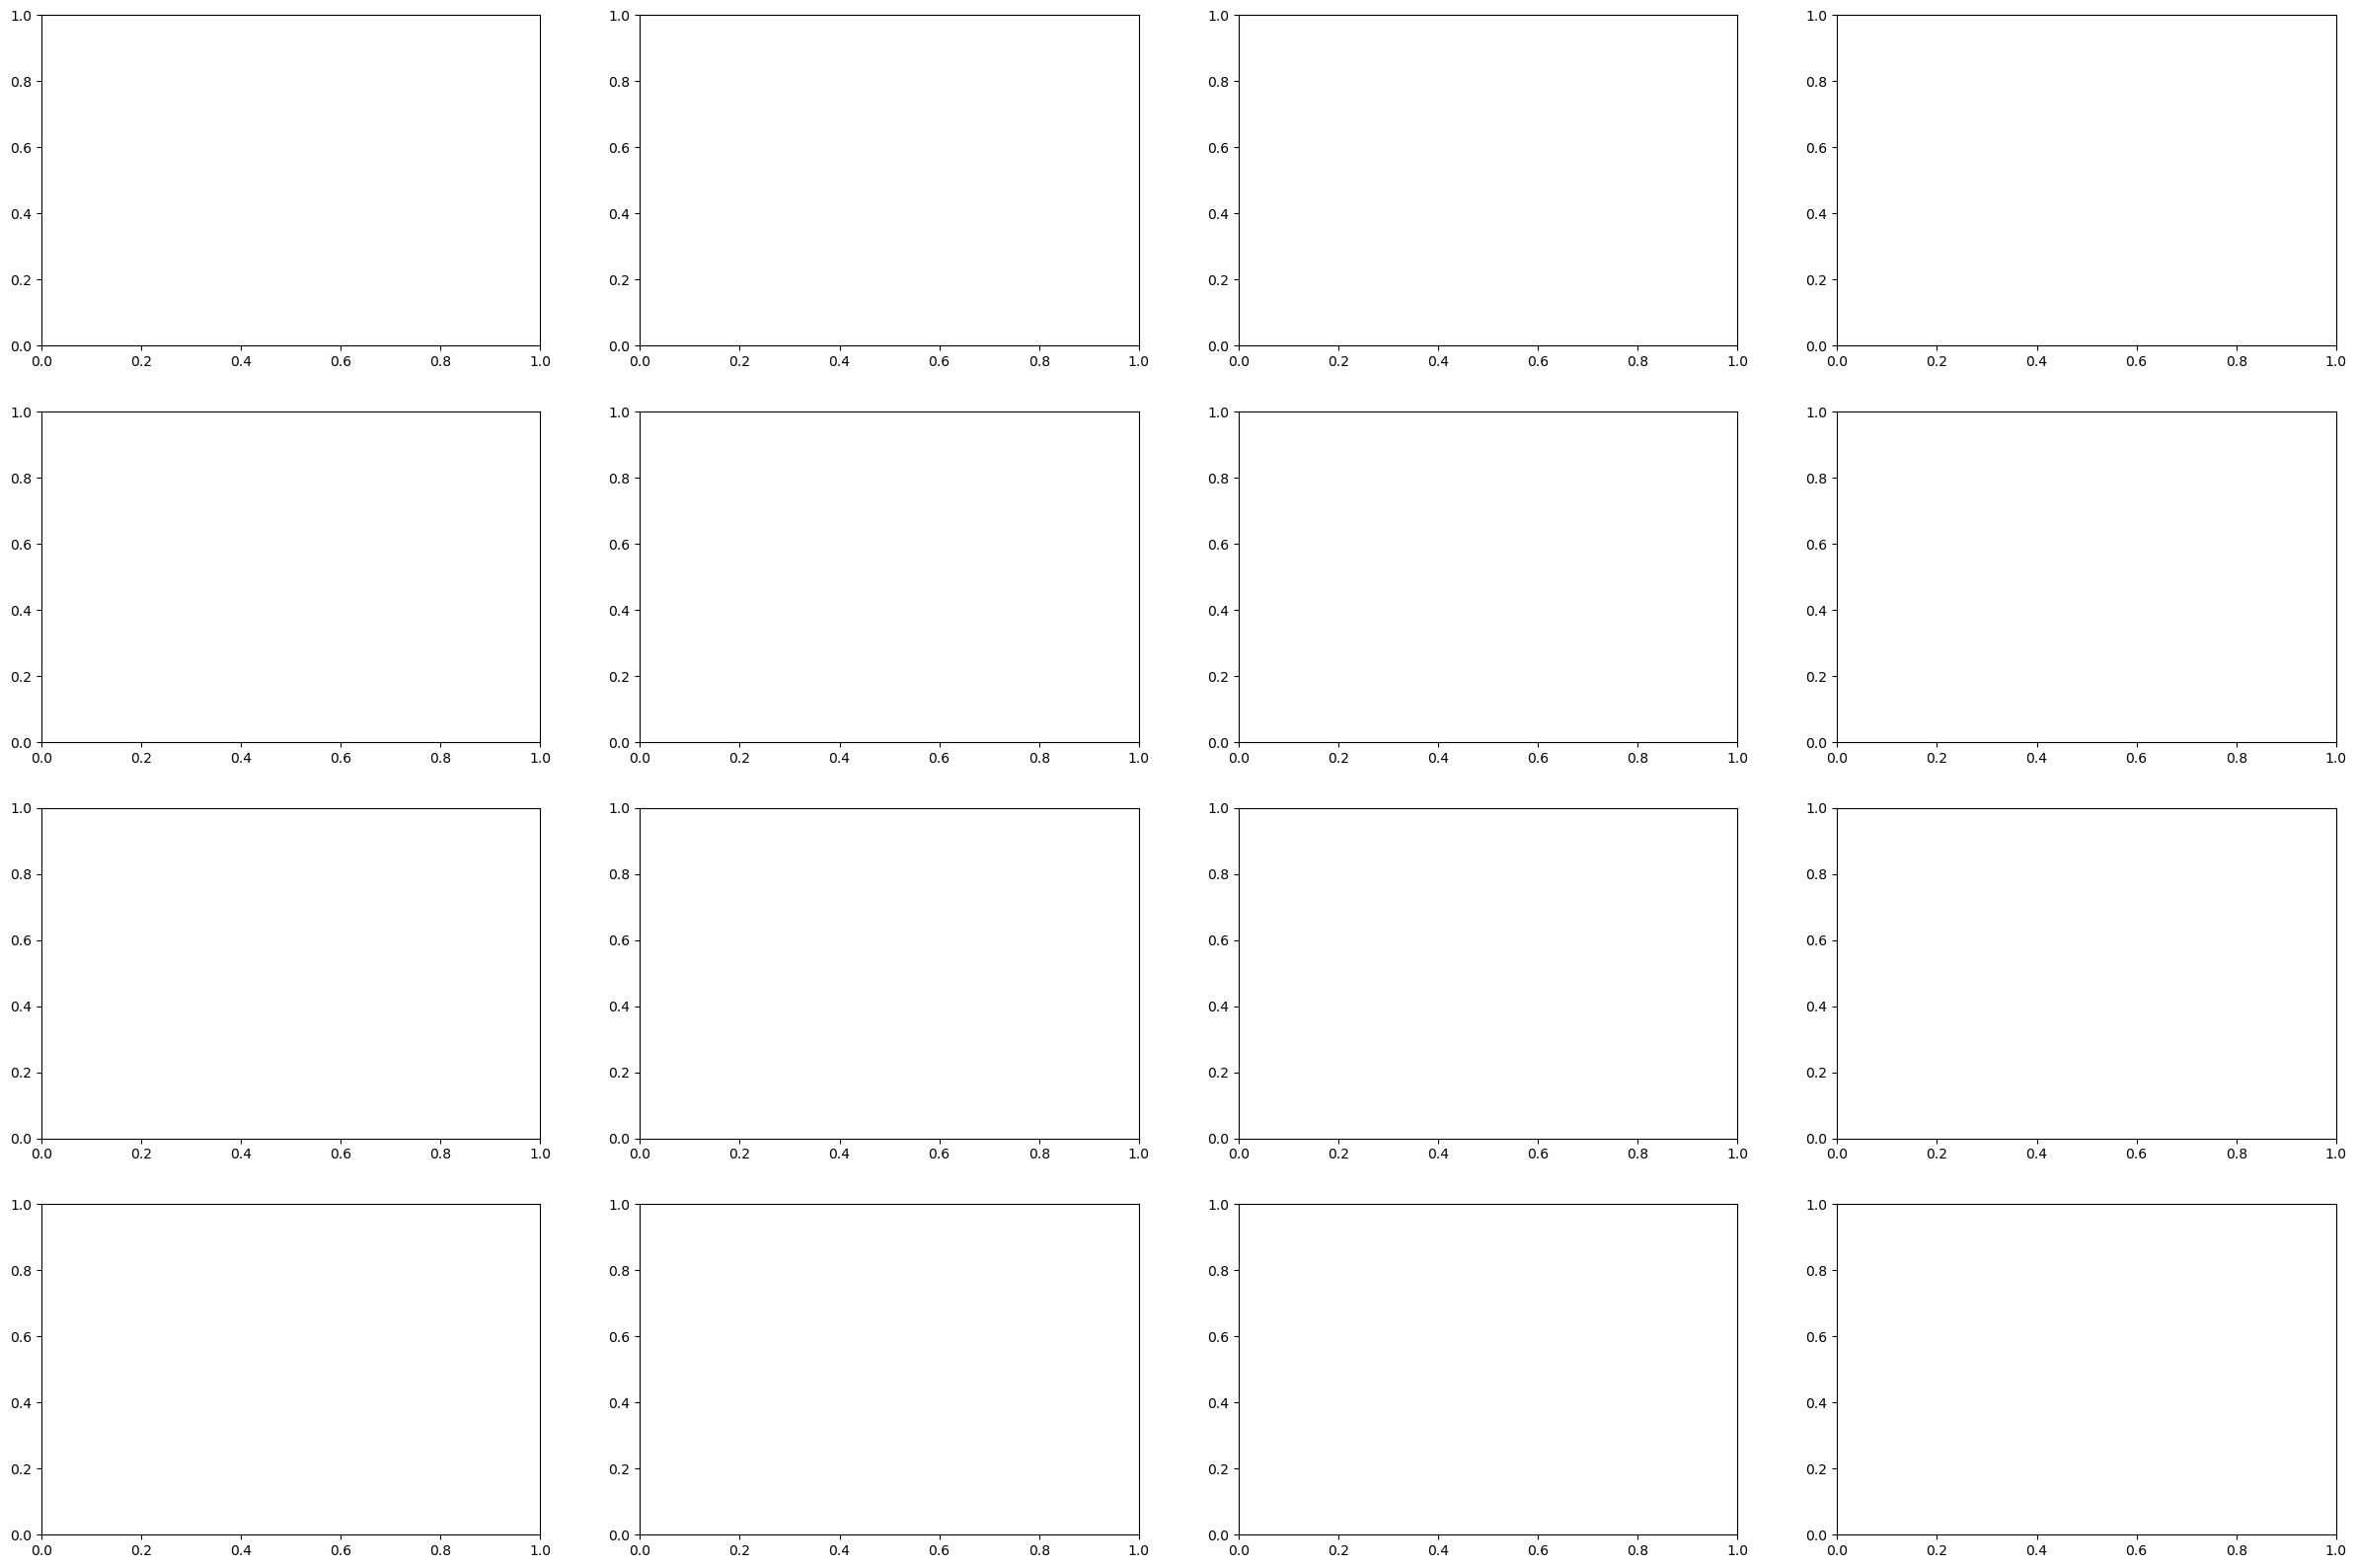

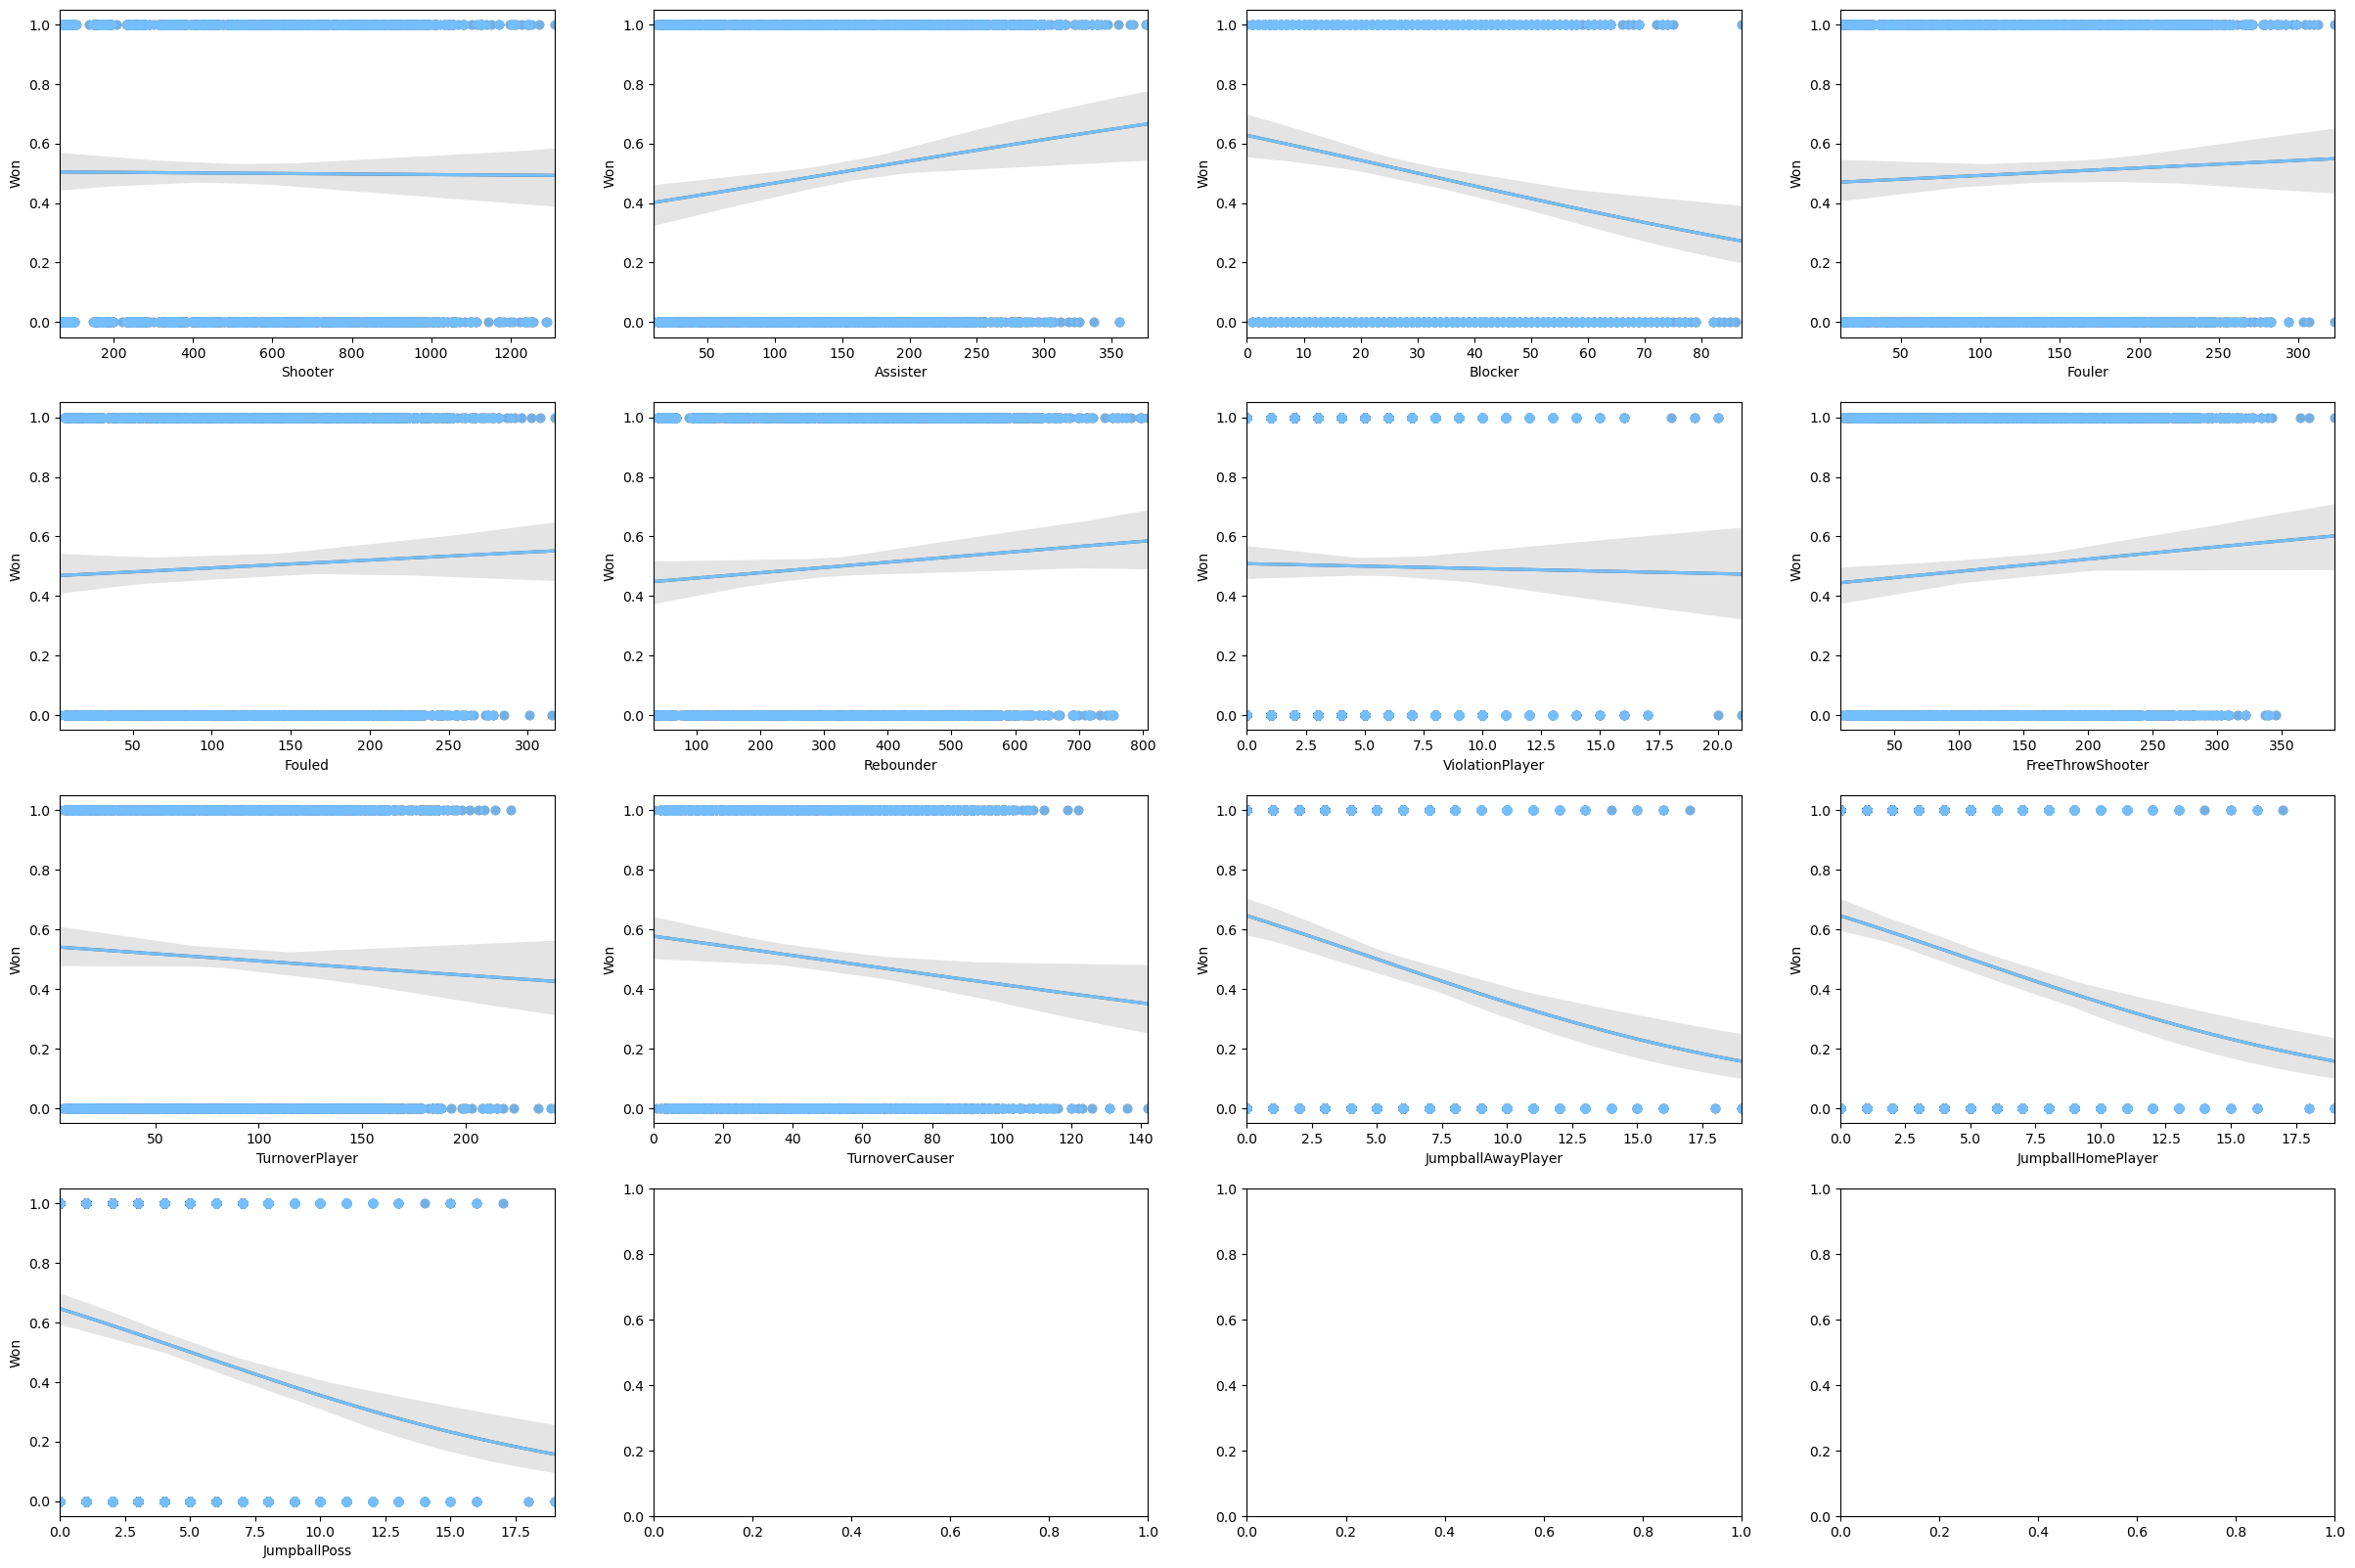

In [38]:
import math
PAIRS_NCOL = 4

pairs_nrow = math.ceil(len(PLAYER_COLS) / PAIRS_NCOL)
fig, ax = plt.subplots(
      figsize = (30, 20)
    , ncols = PAIRS_NCOL
    , nrows = pairs_nrow
)
for i, p in enumerate(PLAYER_COLS):
    sns.regplot(
          x = p
        , y = RESPONSE
        , data = dfp
        , ax = ax[i % PAIRS_NCOL] if pairs_nrow == 1 else ax[math.floor(i / PAIRS_NCOL), i % PAIRS_NCOL]
        , ci = 100
        , color = color_0
        , logistic = True
    )
    sns.regplot(
          x = p
        , y = RESPONSE
        , data = dfp
        , ax = ax[i % PAIRS_NCOL] if pairs_nrow == 1 else ax[math.floor(i / PAIRS_NCOL), i % PAIRS_NCOL]
        , ci = 0
        , color = color_1
        , logistic = True
    )
plt.show()